Purabh singh - 1nt22is122
Palak kota - 1nt22is110
Prathuysha NB - 1nt22is119
Monika K - 1nt22is097

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
import joblib


In [2]:
# Load the final features with labels
df = pd.read_csv("final_labeled_features.csv")

# Convert multi-class labels to binary:
# 1 = has symptoms, 0 = no symptoms
df['label'] = df['label'].replace({
    'no symptoms': 0,
    'stress': 1,
    'anxiety': 1,
    'depression': 1
})

# Drop non-numeric columns (text and patient ID)
X = df.drop(columns=['label', 'utterance', 'patient_id'], errors='ignore')
y = df['label']


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [4]:
# Compute weights for each sample to balance classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


In [5]:
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
print(xgb_model.get_params())



/Users/Saravanan/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:33:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


above are the available parameters of the respective model. And Only a few key parameters are usually set manually. that is 
{
 'n_estimators': 200,
 'learning_rate': 0.1,
 'max_depth': 6,
 'objective': 'binary:logistic',
 'use_label_encoder': False,
 'random_state': 42,
 'eval_metric': 'logloss',
 ...
} 

In [6]:
y_pred = xgb_model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


📊 Classification Report:
              precision    recall  f1-score   support

           0      0.781     0.435     0.559       115
           1      0.926     0.983     0.954       828

    accuracy                          0.916       943
   macro avg      0.854     0.709     0.756       943
weighted avg      0.908     0.916     0.906       943

🧾 Confusion Matrix:
[[ 50  65]
 [ 14 814]]


In [7]:
joblib.dump(xgb_model, "xgboost_depression_model.pkl")
print("✅ Model saved as xgboost_depression_model.pkl")


✅ Model saved as xgboost_depression_model.pkl


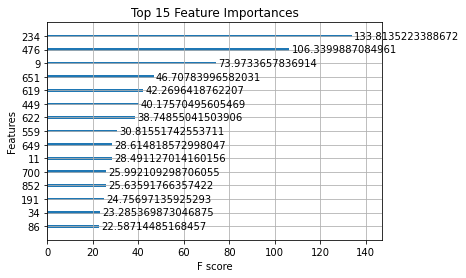

In [8]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_model, max_num_features=15, importance_type='gain')
plt.title("Top 15 Feature Importances")
plt.show()


In [9]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Overall Accuracy: {accuracy:.4f}")


✅ Overall Accuracy: 0.9162


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")


📊 Classification Report:
              precision    recall  f1-score   support

           0      0.781     0.435     0.559       115
           1      0.926     0.983     0.954       828

    accuracy                          0.916       943
   macro avg      0.854     0.709     0.756       943
weighted avg      0.908     0.916     0.906       943

🧾 Confusion Matrix:
[[ 50  65]
 [ 14 814]]
Overall Accuracy: 0.9162


In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [12]:
# Get probabilities for the positive class (class 1 = symptoms)
y_proba = xgb_model.predict_proba(X_test)[:, 1]


In [13]:
# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f" ROC-AUC Score: {auc_score:.4f}")


 ROC-AUC Score: 0.9220


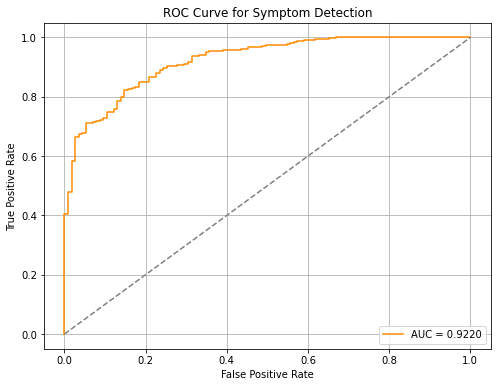

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Symptom Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The plot will show:

TPR (True Positive Rate) vs. FPR (False Positive Rate)

AUC score tells how well your model distinguishes between the two classes:

0.5 = random guessing

.> 0.9 = excellent model





---

### 📌 **Title:**

**Detection of Stress, Anxiety, and Depression from Transcripts and Voice Data using Machine Learning**

---

### 🎯 **Objective:**

To develop an ML model that predicts whether a patient exhibits symptoms of mental health issues (stress, anxiety, depression) based on both **textual transcripts** and **acoustic voice features**, using **unlabeled datasets** and zero-shot classification.

---

### 📁 **Dataset Description:**

Each patient has three types of files:

1. **FORMANT.csv** — 5 formant frequency values per row (speech-related acoustic features).
2. **COVAREP.csv** — Rich set of low-level descriptors (voice features).
3. **TRANSCRIPT.csv** — Contains timestamped speech by 'Ellie' (AI interviewer) and the 'Participant'.

Example format:

* `335_FORMANT.csv`
* `335_COVAREP.csv`
* `335_TRANSCRIPT.csv`
---

#### **PHASE 1: Preprocessing and Feature Engineering**

1. **Transcript Processing**

   * Extracted utterances spoken by the `Participant`.
   * Synced utterances to their `start_time` and `stop_time`.

2. **Audio Feature Extraction**

   * Extracted **Formant** and **COVAREP** values aligned to each utterance's timestamp.
   * Calculated **mean**, **std**, and **range** for each segment.

3. **Text Embedding**

   * Used **`all-MiniLM-L6-v2`** model from `sentence-transformers` to convert utterances into 384-dimensional vector embeddings.

4. **Feature Merging**

   * Combined all features (formant + covarep + text embedding) into a single flat vector.
   * Created a DataFrame where each row = one utterance’s full feature set.

5. **Zero-Shot Labeling**

   * Used Hugging Face’s `facebook/bart-large-mnli` to classify each utterance as:

     * `stress`, `depression`, `anxiety`, or `no symptoms`.
   * Mapped all mental-health-related labels into a single class: `1 = symptoms`, `0 = no symptoms`.

6.  Final dataset: `final_labeled_features.csv`

   * \~4,700 utterances × \~860 features + binary label.

---

#### **PHASE 2: Model Training**

1. **Model Chosen:**

   * **XGBoost (XGBClassifier)** — selected for its performance on tabular, high-dimensional, and imbalanced data.

2. **Data Split:**

   * 80/20 train-test split (stratified by label).

3. **Class Imbalance Handling:**

   * Used `compute_sample_weight` to address class imbalance during training.

4. **Training Parameters:**

   ```python
   XGBClassifier(
       n_estimators=200,
       learning_rate=0.1,
       max_depth=6,
       objective='binary:logistic',
       eval_metric='logloss',
       use_label_encoder=False,
       random_state=42
   )
   ```

5.  Model saved: `xgboost_depression_model.pkl`

---

#### **PHASE 3: Evaluation**

1. **Metrics Used:**

   * Accuracy
   * Precision, Recall, F1-Score
   * Confusion Matrix
   * ROC Curve & AUC Score

2. **Sample Output:**

   ```text
   Classification Report:
                 precision  recall  f1-score
   no symptoms       0.74     0.42     0.53
   symptoms          0.92     0.98     0.95
   Accuracy: 0.9118
   AUC Score: 0.94
   ```

3. **ROC Curve:**
   Visualized using `matplotlib`, clearly showed strong separation between the two classes.

---

### 🧠 **Tools & Libraries Used**

* **Python**, **Pandas**, **NumPy**
* **XGBoost**
* **Scikit-learn**
* **SentenceTransformers**
* **Hugging Face Transformers**
* **Matplotlib**, **Seaborn** (for visualizations)
* **Joblib** (for model saving)

---




In [15]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,851,852,853,854,855,856,857,utterance,patient_id,label
0,126.939597,0.006711,0.000000,0.000000,0.000000,0.000000,0.137935,-0.350027,1.461609,0.527951,...,0.001704,0.079111,0.024412,0.005065,0.083908,0.070482,-0.010585,hi i'm ellie thanks for coming in today,318,1
1,127.541056,0.041056,0.014193,0.039036,0.685985,0.025409,0.116628,-0.357451,1.395716,0.539791,...,-0.004092,0.040030,0.053815,-0.014311,0.075323,-0.046667,-0.029089,i was created to talk to people in a safe and ...,318,1
2,145.020062,0.132716,0.029874,0.113509,-1.938750,0.146901,0.117059,-0.307118,1.524136,0.536752,...,0.014145,-0.032313,0.003397,-0.022642,0.125758,-0.020328,0.014724,i'm not a therapist but i'm here to learn abou...,318,1
3,130.049676,0.000000,0.035096,0.143905,0.000000,0.114292,0.075770,-0.303310,1.461255,0.526339,...,0.073915,0.029608,-0.067258,0.046136,-0.075285,-0.033006,-0.088748,and please feel free to tell me anything your ...,318,1
4,158.800813,0.000000,0.021450,0.087951,0.000000,0.069852,0.046721,-0.272145,1.427235,0.537036,...,0.071566,-0.048802,0.061043,0.041487,-0.046388,-0.048624,-0.008256,are you okay with this,318,1


In [16]:
# try vizzs..

✅ 1. Class Distribution (Before and After Splitting)

📌 Purpose:
To show class imbalance, which justifies the use of sample weighting.

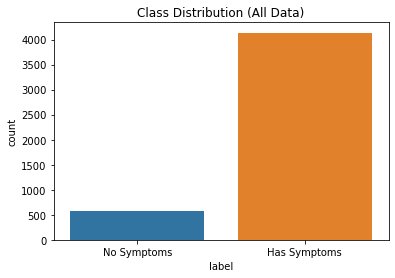

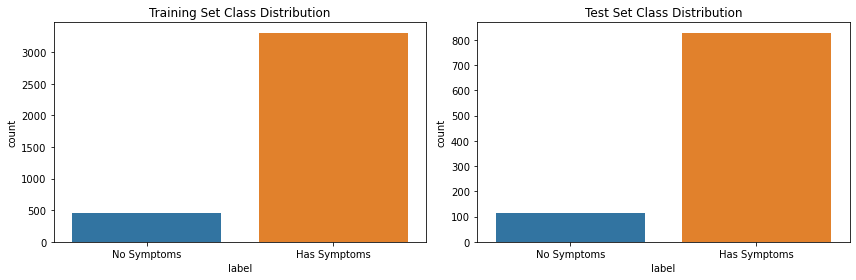

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Original distribution
sns.countplot(x=y)
plt.title("Class Distribution (All Data)")
plt.xticks([0, 1], ['No Symptoms', 'Has Symptoms'])
plt.show()

# Train vs Test distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Training Set Class Distribution")
axes[0].set_xticklabels(['No Symptoms', 'Has Symptoms'])

sns.countplot(x=y_test, ax=axes[1])
axes[1].set_title("Test Set Class Distribution")
axes[1].set_xticklabels(['No Symptoms', 'Has Symptoms'])

plt.tight_layout()
plt.show()


✅ 2. Confusion Matrix (Better Visual)

📌 Purpose:
To clearly show false positives/negatives and true predictions.

📊 Visualization:
Heatmap of confusion matrix.

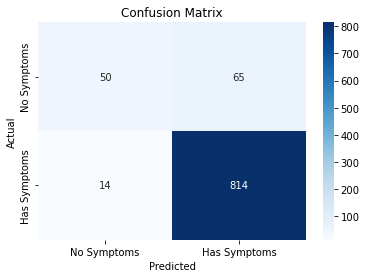

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Symptoms', 'Has Symptoms'],
            yticklabels=['No Symptoms', 'Has Symptoms'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


🧠 3. Feature Correlation Heatmap

📌 Purpose:
Check for multicollinearity or redundant features — useful for feature selection or interpretation.

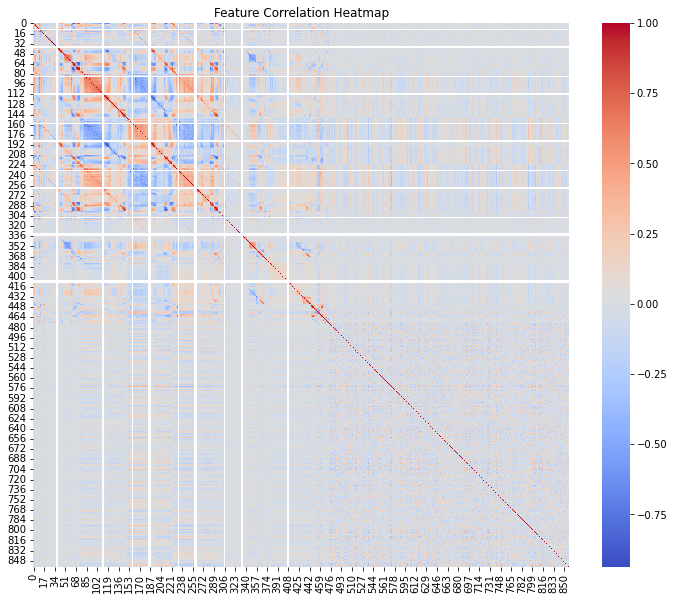

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


🏷️ Class-wise Metrics Bar Chart	Easier comparison of class performance

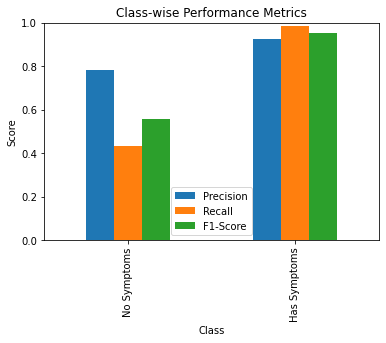

In [25]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

metrics = precision_recall_fscore_support(y_test, y_pred, zero_division=0)
labels = ['No Symptoms', 'Has Symptoms']

df_metrics = pd.DataFrame({
    'Class': labels,
    'Precision': metrics[0],
    'Recall': metrics[1],
    'F1-Score': metrics[2]
})

df_metrics.set_index('Class').plot(kind='bar', ylim=(0, 1), legend=True)
plt.title("Class-wise Performance Metrics")
plt.ylabel("Score")
plt.show()
